In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Functions used:

In [67]:
def varBeta(regr, method, lmbd = 0):
    if method == 'ols':
        Bvar = np.sqrt(np.diag(regr.betaVar))
        return Bvar, regr.sigma_y
    if method == 'ridge':
        sigma = regr.sigma_y
        x = regr.symX
        W = np.linalg.inv(x+lmbd*np.eye(x.shape[0]))@x
        Bvar = np.sqrt(np.diag(sigma*W@np.linalg.inv(x)@W.T))
        
        return Bvar, sigma
    else:
        raise ValueError('method needs to be either "ols" or "ridge"')
    
def printvar(regr,Bvar,deg=5):
    mse = regr.squared_error()
    r2 = regr.r2score()
    print('MSE: ', mse)
    print('R2: ', r2)
    print('----- Conf. int.: -----')
    for i in range(len(Bvar)):
        print('B{:}: {:f} {} {:f}'.format(i,regr.beta[i],u'\xb1',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=regr.beta,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')
    
    
    return mse,r2

In [33]:
def printvar_lasso(mse,r2,Bvar,reg, deg = 5):
    betas = np.zeros((len(Bvar),))
    print('MSE: ', mse)
    print('R2: ', r2)
    print('----- Conf. int.: -----')
    for i in range(len(Bvar)):
        beta = reg.coef_[i]
        betas[i] = beta
        print('B{:}: {:f} {} {:f}'.format(i,beta,u'\xb1',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=betas,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')

In [77]:
def print_scores_with_resmpl(X,z, lmbd=0, method = 'ols', smplsize=1000):
    if method.lower() not in ['ols','ridge','lasso']:
        raise ValueError('Invalid method flag, {}'.format(method))
    if method.lower() == 'ols' and lmbd != 0:
        raise ValueError('lmbd != 0 does not make sense for OLS.')
    if method.lower() == 'lasso':
        from sklearn.linear_model import Lasso 

    ## Without resampling
    if method.lower() == 'ols':
        regr = tools.Regression(X,z)
        zpred = regr.yhat
        mse = regr.squared_error()
        r2 = regr.r2score()
        out = tools.k_fold_val(x,y,z, method = 'ols')
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, method = 'ols', r2_score=True, smplsize=smplsize)
    if method.lower() == 'ridge':
        regr = tools.Regression(X,z,lmbd = lmbd)
        zpred = regr.yhat
        mse = regr.squared_error()
        r2 = regr.r2score()
        out = tools.k_fold_val(x,y,z, method = 'ridge', lmbd=lmbd)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lmbd, method = 'ridge', r2_score=True, smplsize=smplsize)
    if method.lower() == 'lasso':
        reg = Lasso(alpha = lmbd)
        reg.fit(X,z)
        zpred = reg.predict(X)
        mse = tools.squared_error(z,zpred)
        r2 = tools.r2score(z,zpred)
        out = tools.k_fold_val(x,y,z, method = 'lasso', lmbd=lmbd)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lmbd, method = 'lasso', r2_score=True, smplsize=smplsize)

    print('--------- Without resampling ---------')
    print('MSE: ', mse)
    print('R2: ', r2)

    ## With k-fold
    k_R2_in = out[0]
    k_MSE_in = out[1]
    k_R2_out = out[2]
    k_MSE_out = out[3]

    print('------- With k-fold validation -------')
    print('MSE (in): ', k_MSE_in)
    print('R2 (in): ', k_R2_in)
    print('MSE (out): ', k_MSE_out)
    print('R2 (out): ', k_R2_out)

    ## With bootstrap
    print('----------- With bootstrap -----------')
    print('MSE (out): ', np.average(b_MSE_out))
    print('R2 (out): ', np.average(b_R2_out))

# Regression analysis
Performed on the data set is the franke function for x,y$\in$[0,1], defined below with additional variables used in the regression analysis

In [27]:
deg = 5 # degree of polynomial fit
N = 2000 # Data points
lambd = 0.01
noise = 0.1

x,y,z,noise = tools.generate_data(N=N, noise=noise)

X = tools.get_X_poly2D(x,y,deg=deg)

## Ordinary linear regression


Do regression and print MSE, R2 and beta with conf.int.

In [6]:
# X = tools.get_X_poly2D(x,y,deg=deg)

def olsBeta(X,z, errors = False):
    regr = tools.Regression(X,z,lmbd = 0)

    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method='ols')
    
    if errors == True:
        mse,r2 = printvar(regr,Bvar)
        
    return regr.beta,Bvar,sigma

### - Mean squared error and R2-score
MSE and R2 of ordinary linear regression, with and without k-fold and bootstrap

In [78]:
print_scores_with_resmpl(X,z, method = 'ols', smplsize=1000)

--------- Without resampling ---------
MSE:  0.011630949401532312
R2:  0.8718329698063473
------- With k-fold validation -------
MSE (in):  0.011556890046793604
R2 (in):  0.8723115488730819
MSE (out):  0.011864149585266649
R2 (out):  0.8689125844322063
----------- With bootstrap -----------
MSE (out):  0.012197386124725764
R2 (out):  0.8469821249932149


In [8]:
## VAR PLoT
# plt.figure(figsize=(10,6))
# plt.subplot(2,2,1)
# plt.imshow(Bvar)
# plt.subplot(1,2,2)
# plt.errorbar(np.arange(len(Bvar)), regr.beta/regr.beta, yerr = np.sqrt(np.diag(Bvar)), fmt=".")
# plt.tight_layout()

In [9]:
# df = tools.get_exp_coeffs(Bvar)
# df.columns = ['x^{}'.format(i) for i in df.columns]
# df.index = ['y^{}'.format(i) for i in df.index]
# print(df.to_latex(na_rep='', escape = False,  column_format='lllllll'))

##### Beta coefficients and their confidence intervals

MSE:  0.011630949401532312
R2:  0.8718329698063473
----- Conf. int.: -----
B0: 0.384642 ± 0.044824
B1: 4.071236 ± 0.474005
B2: 7.389450 ± 0.475029
B3: -10.241731 ± 2.206240
B4: -14.425860 ± 1.798619
B5: -31.380557 ± 2.214729
B6: -5.314420 ± 4.901262
B7: 22.749281 ± 3.703494
B8: 38.679329 ± 3.791105
B9: 42.691431 ± 4.926614
B10: 27.809862 ± 5.146926
B11: -33.809008 ± 3.966875
B12: -6.617896 ± 3.721571
B13: -44.822619 ± 3.950117
B14: -19.392499 ± 5.128895
B15: -16.632938 ± 2.049502
B16: 19.215431 ± 1.796074
B17: -5.447688 ± 1.722855
B18: 9.236784 ± 1.761850
B19: 15.569334 ± 1.734900
B20: 0.305264 ± 2.004291


(array([  0.38464197,   4.07123648,   7.38944971, -10.24173098,
        -14.42585968, -31.38055736,  -5.31441973,  22.74928147,
         38.67932939,  42.69143119,  27.80986229, -33.80900752,
         -6.61789635, -44.82261854, -19.39249876, -16.63293828,
         19.21543108,  -5.44768801,   9.23678406,  15.56933416,
          0.30526417]),
 array([0.0448241 , 0.47400489, 0.47502928, 2.20623971, 1.79861875,
        2.21472862, 4.90126185, 3.70349441, 3.79110488, 4.92661371,
        5.14692568, 3.96687507, 3.7215713 , 3.95011661, 5.12889517,
        2.04950239, 1.7960738 , 1.72285511, 1.76184952, 1.73490021,
        2.00429103]),
 0.011760312842803147)

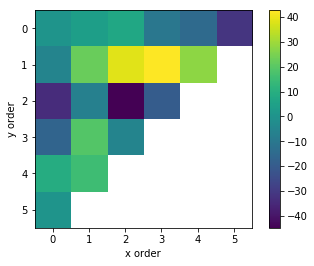

In [66]:
olsBeta(X,z, errors=True)

# Ridge regression

In [65]:
# X = tools.get_X_poly2D(x,y,deg=deg)
def ridgeBeta(X,z,lambd, errors = False):
    regr = tools.Regression(X,z,lmbd = lambd)
    
    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method = 'ridge', lmbd = lambd)

    if errors == True:
        mse,r2 = printvar(regr, Bvar)
    
    return regr.beta, Bvar, sigma
    

### - Mean squared error and R2-score
MSE and R2 of ridge regression, with and without k-fold and bootstrap

In [72]:
print_scores_with_resmpl(X,z, lmbd=lambd, method = 'ridge', smplsize=1000)

------- Without resampling -------
MSE:  0.013743220966329881
R2:  0.8485568326591134
------- With k-fold validation -------
MSE (in):  0.014372594300745535
R2 (in):  0.8413923369184237
MSE (out):  0.014671108767649713
R2 (out):  0.8381649261259175
------- With bootstrap -------
MSE (out):  0.014798009914319501
R2 (out):  0.7992801541928468


##### Beta coefficients and their confidence intervals

MSE:  0.013743220966329881
R2:  0.8485568326591134
----- Conf. int.: -----
B0: 0.853391 ± 0.024193
B1: 1.578100 ± 0.143930
B2: 1.445800 ± 0.142215
B3: -6.696984 ± 0.337876
B4: 0.967441 ± 0.291652
B5: -7.752727 ± 0.337079
B6: 2.660414 ± 0.253086
B7: -1.595517 ± 0.269969
B8: 2.006817 ± 0.272980
B9: 5.037907 ± 0.251559
B10: 4.826920 ± 0.258973
B11: -1.145942 ± 0.267007
B12: 1.373164 ± 0.300644
B13: 0.584781 ± 0.273570
B14: 4.840275 ± 0.260739
B15: -2.885955 ± 0.252077
B16: 1.372775 ± 0.292659
B17: -1.880863 ± 0.374362
B18: 0.816244 ± 0.378541
B19: -1.930280 ± 0.290802
B20: -4.587824 ± 0.248870


(array([ 0.85339125,  1.57809994,  1.44580004, -6.69698387,  0.96744061,
        -7.75272666,  2.66041382, -1.59551677,  2.00681699,  5.03790748,
         4.82692008, -1.14594206,  1.37316444,  0.58478055,  4.84027545,
        -2.88595462,  1.37277455, -1.88086328,  0.81624437, -1.93027965,
        -4.58782367]),
 array([0.02419269, 0.14393019, 0.14221463, 0.33787643, 0.29165184,
        0.33707934, 0.25308624, 0.26996855, 0.2729799 , 0.25155897,
        0.25897251, 0.26700718, 0.30064389, 0.27357025, 0.2607392 ,
        0.25207693, 0.29265947, 0.37436235, 0.37854077, 0.29080203,
        0.24886953]),
 0.013896077822376018)

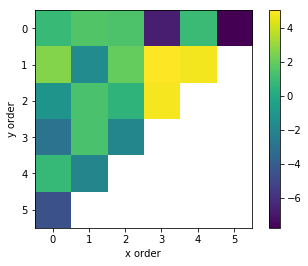

In [35]:
ridgeBeta(X,z,lambd= lambd, errors=True)

# Lasso regression

In [12]:
from sklearn.linear_model import Lasso

def lassoBeta(X,z,lambd, errors = False):
    reg = Lasso(alpha = lambd)
    reg.fit(X,z)
    zpred = reg.predict(X)

    mse = tools.squared_error(z,zpred)
    r2 = tools.r2score(z,zpred)
    sigma = 1/(N-deg-1) * np.sum((z-zpred)**2)
    Bvar = np.sqrt(np.diag(np.linalg.inv(X.T@X)*sigma))
    if errors == True:
        printvar_lasso(mse,r2,Bvar,reg,deg)
        
    return reg.coef_, Bvar, sigma

### - Mean squared error and R2-score
MSE and R2 of lasso regression, with and without k-fold and bootstrap

In [30]:
print_scores_with_resmpl(X,z, lmbd=lambd, method = 'lasso', smplsize=1000)

------- Without resampling -------
MSE:  0.03471208582373778
R2:  0.617490817106509
------- With k-fold validation -------
MSE (in):  0.03788231310846023
R2 (in):  0.5821742558570622
MSE (out):  0.038146076047751304
R2 (out):  0.5803478930423245
------- With bootstrap -------
MSE (out):  0.03844988496002034
R2 (out):  -0.28201230375797925


##### Beta coefficients and their confidence intervals
Confidence intervals not correct, using formula for OLS 

MSE:  0.03471208582373778
R2:  0.617490817106509
----- Conf. int.: -----
B0: 0.000000 ± 0.077125
B1: -0.143627 ± 0.815579
B2: -0.384565 ± 0.817342
B3: -0.402616 ± 3.796086
B4: -0.000000 ± 3.094728
B5: -0.000000 ± 3.810692
B6: -0.000000 ± 8.433178
B7: -0.000000 ± 6.372283
B8: -0.000000 ± 6.523026
B9: -0.000000 ± 8.476798
B10: -0.000000 ± 8.855870
B11: -0.000000 ± 6.825459
B12: -0.000000 ± 6.403386
B13: -0.000000 ± 6.796624
B14: -0.000000 ± 8.824847
B15: -0.000000 ± 3.526402
B16: -0.000000 ± 3.090349
B17: -0.000000 ± 2.964368
B18: -0.000000 ± 3.031462
B19: -0.000000 ± 2.985093
B20: -0.000000 ± 3.448610


(array([ 0.        , -0.14362697, -0.38456465, -0.40261603, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]),
 array([0.07712496, 0.81557925, 0.81734181, 3.79608594, 3.0947278 ,
        3.81069207, 8.43317756, 6.37228267, 6.52302644, 8.47679831,
        8.85587006, 6.825459  , 6.40338601, 6.79662417, 8.82484653,
        3.52640159, 3.09034892, 2.96436785, 3.03146216, 2.98509281,
        3.44861031]),
 0.03481653543002786)

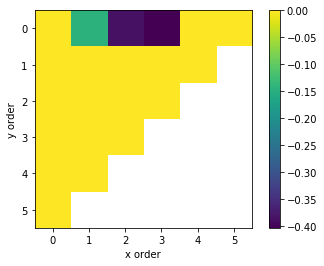

In [43]:
lassoBeta(X,z,lambd=0.01, errors=True)

# Plot beta as a function of lambda

/Users/heine2307/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


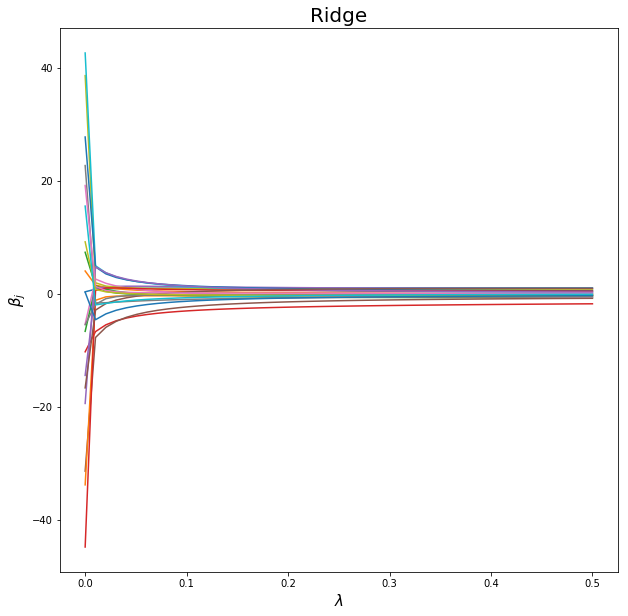

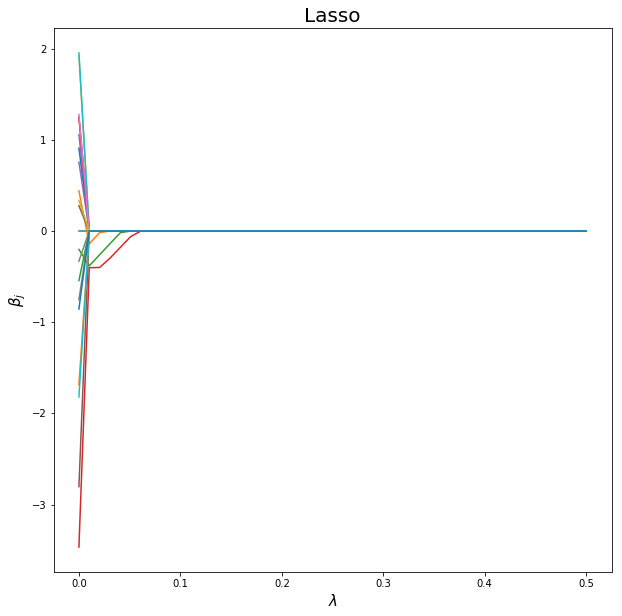

In [80]:
runs = 50
bnum = 10

# OLS beta is not dependent of lambda, so every point is the same
Sb,Sv,Ss = olsBeta(X,z)
Bnum = np.argsort(np.abs(Sb))
bnum = Bnum[0]
#print('Bnum: ',bnum)
Sbeta = np.ones(runs)*Sb[bnum]
Svar = np.ones(runs)*Sv[bnum]
Ssig = np.ones(runs)*Ss

Rbeta = np.zeros(runs)
Rvar = np.zeros(runs)
Rsig = np.zeros(runs)

Rlist = np.zeros((runs,X.shape[1]))

Lbeta = np.zeros(runs)
Lvar = np.zeros(runs)
Lsig = np.zeros(runs)

Llist = np.zeros((runs,X.shape[1]))

#x = 100*np.log10(np.arange(runs))
# x = np.logspace(-3, 2, runs)
x = np.linspace(0, 0.5, runs)

for i, lambd in enumerate(x):
    Rb,Rv,Rs = ridgeBeta(X,z,lambd=lambd)
    Rbeta[i] = Rb[bnum]
    Rvar[i] = Rv[bnum]
    Rsig[i] = Rs
    Rlist[i][:] = Rb
    
    Lb,Lv,Ls = lassoBeta(X,z,lambd=lambd)
    Lbeta[i] = Lb[bnum]
    Lvar[i] = Lv[bnum]
    Lsig[i] = Ls
    Llist[i][:] = Lb

# #OLS
# plt.plot(x,Sbeta, 'r-')
# plt.fill_between(x,Sbeta+Ssig,Sbeta-Ssig,alpha=0.1,color='r')
# #Ridge
# plt.plot(x,Rbeta, 'b-')
# plt.fill_between(x,Rbeta+Rsig,Rbeta-Rsig,alpha=0.1,color='b')
# #Lasso
# plt.plot(x,Lbeta, 'g-')
# plt.fill_between(x,Lbeta+Lsig,Lbeta-Lsig,alpha=0.1,color='g')

figridge = plt.figure(figsize=[10,10])
#plt.subplot(121)
for i in range(X.shape[1]):
    plt.plot(x,Rlist.T[i])#,'b-')
    plt.fill_between(x,Rlist.T[i]+Rsig,Rlist.T[i]-Rsig,alpha=0.1)#,color='b')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Ridge',fontsize=20)
#plt.legend(['B_{}'.format(i) for i in range(X.shape[1])])
plt.savefig('betaRidge.pdf')

figlasso = plt.figure(figsize=[10,10])
for i in range(X.shape[1]):
    plt.plot(x,Llist.T[i])#,'g-')
    #plt.fill_between(x,Lbeta[i]+Lsig,Lbeta[i]-Lsig,alpha=0.1)#,color='g')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Lasso',fontsize=20)
plt.savefig('betaLasso.pdf')

plt.show()


